### BagOfNgrams

Create vector from sentence

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Kim Suho is looking for a job"])
v.vocabulary_

{'kim': 3, 'suho': 5, 'is': 1, 'looking': 4, 'for': 0, 'job': 2}

set n grams = 2 (bigram)

In [7]:
v = CountVectorizer(ngram_range=(2,2))
v.fit(["Kim Suho is looking for a job"])
v.vocabulary_

{'kim suho': 2, 'suho is': 4, 'is looking': 1, 'looking for': 3, 'for job': 0}

set vector to have both n grams = 1 and 2

In [5]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Kim Suho is looking for a job"])
v.vocabulary_

{'kim': 5,
 'suho': 9,
 'is': 2,
 'looking': 7,
 'for': 0,
 'job': 4,
 'kim suho': 6,
 'suho is': 10,
 'is looking': 3,
 'looking for': 8,
 'for job': 1}

In [8]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [9]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

Preprocess function

In [11]:
def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

In [12]:
preprocess("Thor ate pizza")

'thor eat pizza'

In [13]:
preprocess("Loki is eating pizza")

'Loki eat pizza'

Apply preprocess function to corpus

In [14]:
corpus_processed = [
    preprocess(text) for text in corpus
]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

Apply CountVectorizer with n grams = 1 and 2

In [15]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

convert sample text to vector

In [16]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]])

out of vocabulary (OOV) term and see how bag of ngram generates vector out of it

In [17]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]])

                        0        1       2        3        4       5    6    7       8
                        eat  eat pizza  loki  loki eat loki tall pizza tall thor thor eat

      Thor eat pizza  [ 1        1       0        0        0       1    0    1       1  ]

      Hulk eat pizza  [ 1        1       0        0        0       1    0    0       0  ]

### BAG of n grams on Dataset

In [18]:
import pandas as pd

df = pd.read_json('Datasets/news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [19]:
df.category.value_counts()

,count
category,
BUSINESS,4254
SPORTS,4167
CRIME,2893
SCIENCE,1381


Handle class imbalance with undersampling

In [20]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class

df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [21]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

,count
category,
BUSINESS,1381
SPORTS,1381
CRIME,1381
SCIENCE,1381


Convert text category to a number

In [24]:
df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1,
    'CRIME': 2,
    'SCIENCE': 3
})

In [25]:
df_balanced.head()

,text,category,category_num
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


#### Build a model with original text (no pre processing)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=2022,
    stratify=df_balanced.category_num # create equal number of sample from all the samples in train and test.
)

In [27]:
print(X_train.shape)
X_train.head()

(4419,)


,text
7589,Ovulating Women Prefer Images of Penetration O...
10442,Scientists Discover Spooky Influence On Baby N...
8792,Olympic Race Walker Steps Up To Propose To His...
1733,Beloved Bipedal Bear Named Pedals Believed Kil...
2526,"Elizabeth Smart Gave Birth To Baby Girl, Fathe..."


In [28]:
y_train.value_counts()

,count
category_num,
3,1105
2,1105
0,1105
1,1104


In [29]:
y_test.value_counts()

,count
category_num,
1,277
0,276
3,276
2,276


**Use 1-gram which is nothing but a Bag Of Words (BOW) model**

In [38]:
from sklearn.naive_bayes import MultinomialNB # naive bayes usually good for text problems
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),
     ('Multi_NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



Depend on datasets or problems sometime 1 gram is better than 2 or 3 grams

In [45]:
X_test[:5]

,text
3716,African Nation Slaps Exxon With Fine Nearly 7 ...
608,These Cringe-Worthy Stories Show It Can Be Har...
11172,LISTEN: The Accidental Discovery That Proved T...
1346,Build Loyalty -- The Cost -- $00.00 Remember y...
1356,Man Killed By Michigan Police Wasn't Targeting...


In [46]:
y_pred[:5]

array([0, 3, 3, 0, 2])

In [47]:
y_test[:5]

,category_num
3716,0
608,3
11172,3
1346,0
1356,2



    BUSINESS: 0
    SPORTS: 1
    CRIME: 2
    SCIENCE: 3

**Use 1 and 2-gram**

In [33]:
from sklearn.naive_bayes import MultinomialNB # naive bayes usually good for text problems
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),
     ('Multi_NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



**Use 1 and 3-grams**

In [34]:
from sklearn.naive_bayes import MultinomialNB # naive bayes usually good for text problems
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 3))),
     ('Multi_NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



#### Build model with preprocess text

In [48]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess)

# the preprocess function is already declared in BagOfNgrams tag
'''
def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)
'''

'\ndef preprocess(text):\n    # remove stop words and lemmatize the text\n    doc = nlp(text)\n    filtered_tokens = []\n    for token in doc:\n        if token.is_stop or token.is_punct:\n            continue\n        filtered_tokens.append(token.lemma_)\n    \n    return " ".join(filtered_tokens) \n'

In [49]:
df_balanced.head()

,text,category,category_num,preprocessed_txt
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,GCC Business leader remain confident Face Regi...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review Employees wake morning love impo...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment CEO FreshBooks Talks give build...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,leverage intuition decision making feel safe r...


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt,
    df_balanced.category_num,
    test_size=0.2,
    random_state=2022,
    stratify=df_balanced.category_num # create equal number of sample from all the samples in train and test.
)

In [63]:
print(X_train.shape)
X_train.head()

(4419,)


,preprocessed_txt
7589,ovulate Women prefer Images Penetration Images...
10442,scientist discover Spooky Influence Baby Choices
8792,Olympic Race Walker step Propose boyfriend Rio...
1733,Beloved Bipedal Bear name Pedals believe kill ...
2526,Elizabeth Smart give Birth Baby Girl Father say


In [64]:
y_train.value_counts()

,count
category_num,
3,1105
2,1105
0,1105
1,1104


In [65]:
y_test.value_counts()

,count
category_num,
1,277
0,276
3,276
2,276


In [66]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       276
           1       0.93      0.82      0.87       277
           2       0.81      0.91      0.86       276
           3       0.92      0.83      0.87       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.87      0.86      0.86      1105



f1 score is better when compare with no text preprocessing

#### Plot confusion matrix

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[241,   8,  17,  10],
       [  8, 226,  36,   7],
       [ 17,   3, 252,   4],
       [ 34,   6,   6, 230]])

Text(95.72222222222221, 0.5, 'Truth')

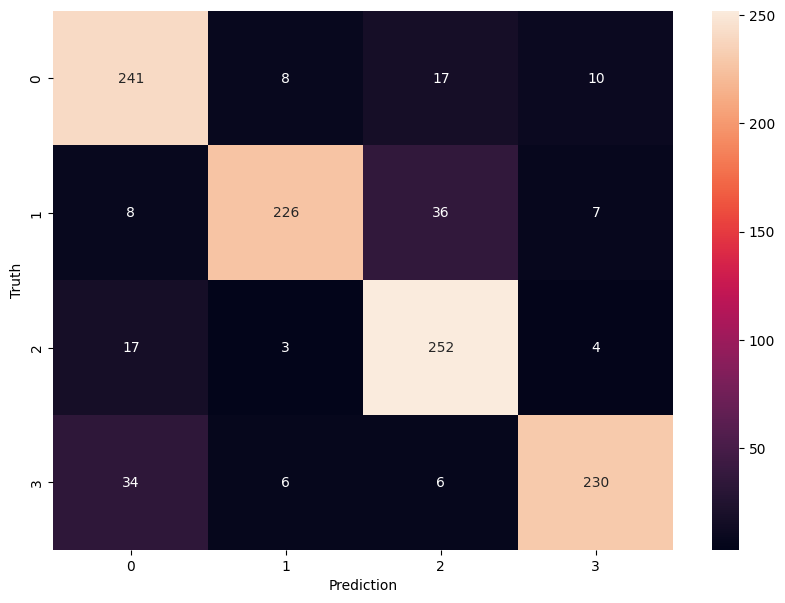

In [69]:
from matplotlib import pyplot as plt
import seaborn as sn

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')